# Weighted Least Squares Regression #

### Generalized Least Squares ###

In [59]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Statistics
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from scipy.stats import t
from statsmodels.stats.diagnostic import het_breuschpagan

# Get Data
from fredapi import Fred
import logging

# Pretty Notation
from IPython.display import display, Math

In [60]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"Open",
        "High Price":"High",
        "Low Price":"Low",
        "Close Price":"Close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2020-01-01":]

In [61]:
# Data for Y
data_y = import_financial_data('AMZN')

y = data_y['Close'].pct_change(1).mul(100).dropna()

y

Date
2020-01-03   -1.213903
2020-01-06    1.488557
2020-01-07    0.209157
2020-01-08   -0.780865
2020-01-09    0.479923
                ...   
2024-10-15    0.079983
2024-10-16   -0.426235
2024-10-17    0.342447
2024-10-18    0.778542
2024-10-21    0.042330
Name: Close, Length: 1208, dtype: float64

In [62]:
# Data for Explanatory Variables
data_x = import_financial_data('WMT')

x = data_x['Close'].pct_change(1).mul(100).dropna()

x

Date
2020-01-03   -0.882799
2020-01-06   -0.203580
2020-01-07   -0.926477
2020-01-08   -0.343170
2020-01-09    1.033059
                ...   
2024-10-15    1.693860
2024-10-16   -0.526638
2024-10-17   -0.406304
2024-10-18    0.519224
2024-10-21   -0.614931
Name: Close, Length: 1208, dtype: float64

In [63]:
# Create the Data for Lineal Regression
ols_df = pd.DataFrame(index = y.index)
ols_df['y'] = y
ols_df['x'] = x

# Drop NaNs
ols_df = ols_df.dropna()

ols_df.index = pd.to_datetime(ols_df.index)

ols_df['constant'] = 1

print(ols_df)

                   y         x  constant
Date                                    
2020-01-03 -1.213903 -0.882799         1
2020-01-06  1.488557 -0.203580         1
2020-01-07  0.209157 -0.926477         1
2020-01-08 -0.780865 -0.343170         1
2020-01-09  0.479923  1.033059         1
...              ...       ...       ...
2024-10-15  0.079983  1.693860         1
2024-10-16 -0.426235 -0.526638         1
2024-10-17  0.342447 -0.406304         1
2024-10-18  0.778542  0.519224         1
2024-10-21  0.042330 -0.614931         1

[1208 rows x 3 columns]


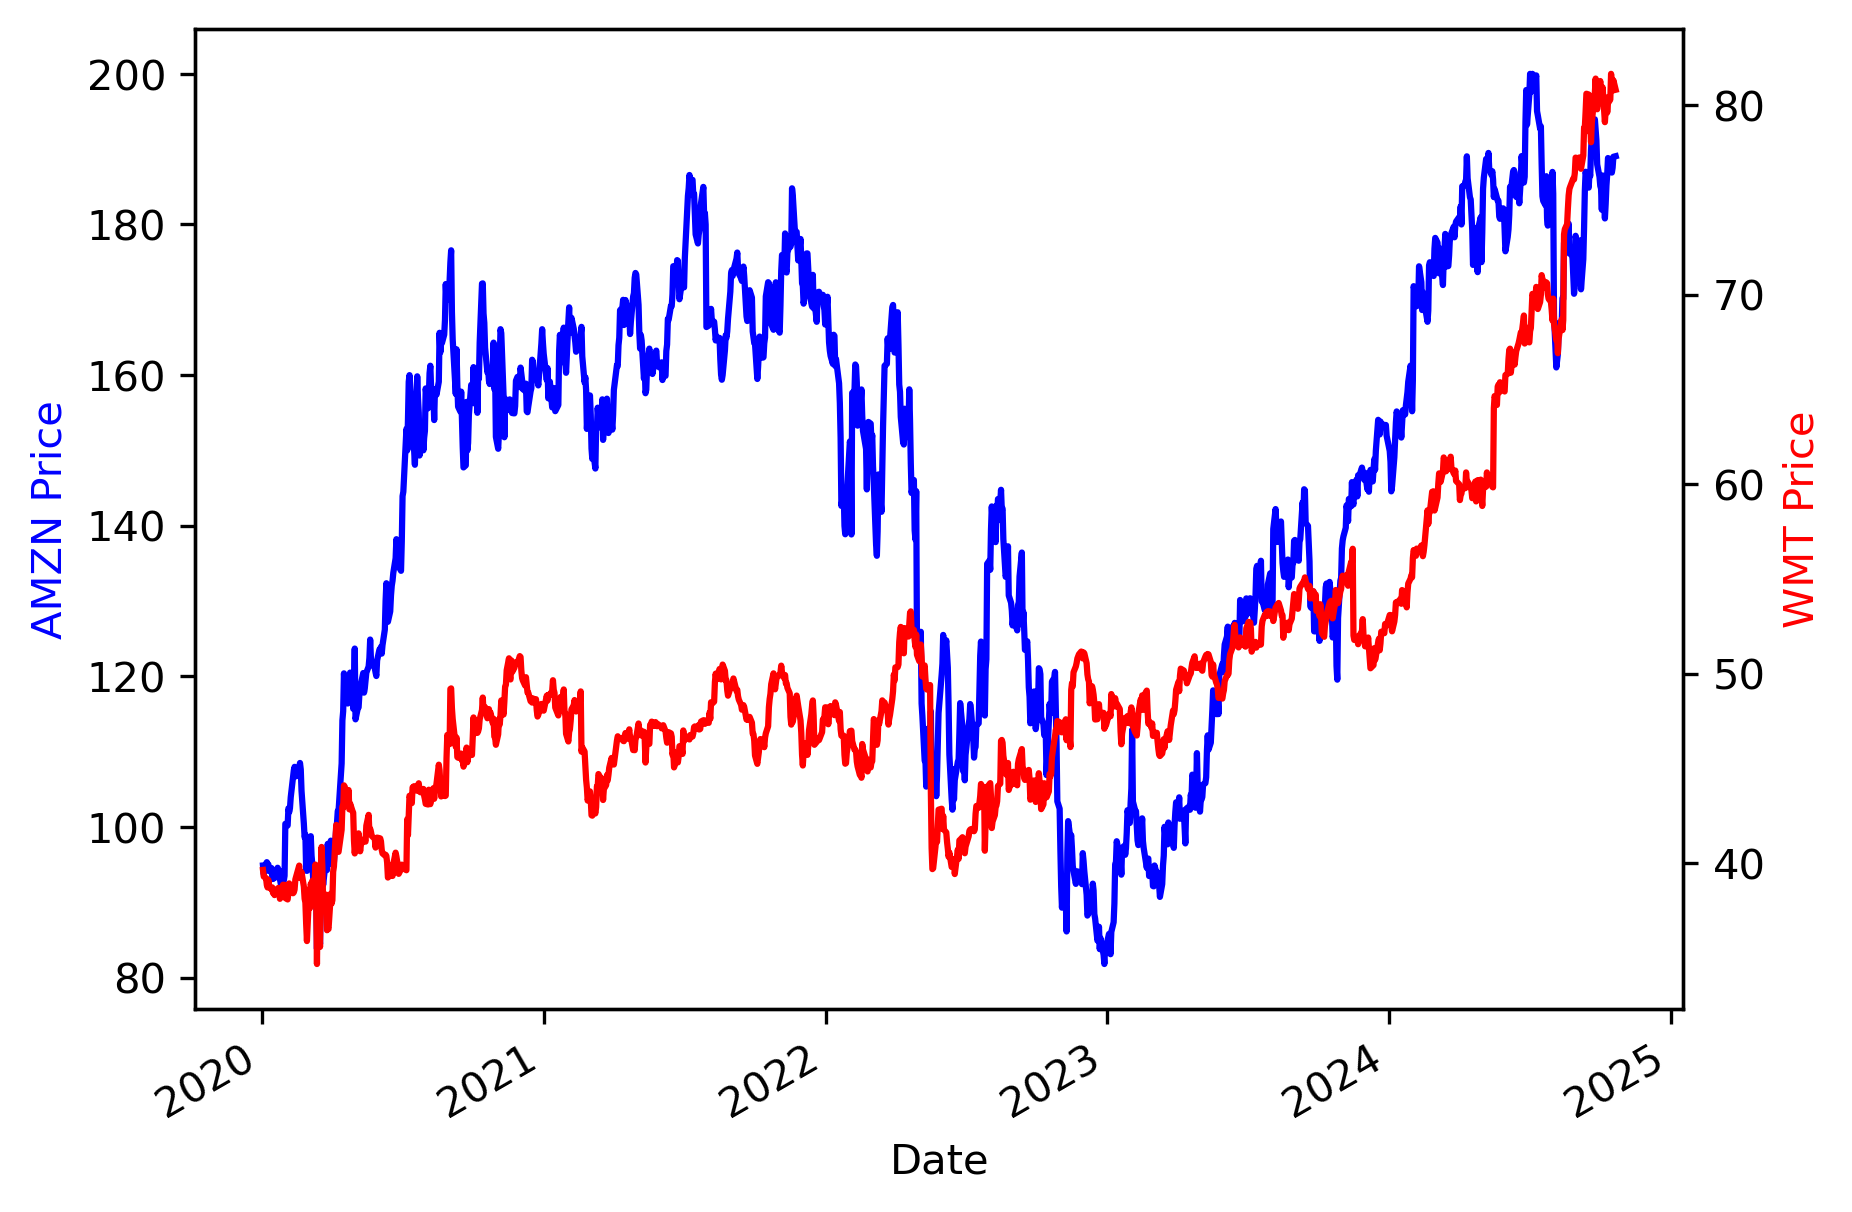

In [64]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# AMZN Price
data_y['Close'].plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'AMZN Price', 
    color='blue'
    )

# WMT Price
ax2 = ax1.twinx()

data_x['Close'].plot(color = 'red', ax = ax2)
ax2.set_ylabel(
    'WMT Price', 
    color='red'
    )

plt.show()

In [65]:
#Model specification
model = sm.OLS(
    ols_df['y'], 
    sm.add_constant(ols_df['x'])
    )   
     
#the results of the model
results = model.fit() 
    
#The Parameters
betas = results.params  

#here we check the summary
print(results.summary())    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     117.6
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           3.29e-26
Time:                        16:18:25   Log-Likelihood:                -2650.8
No. Observations:                1208   AIC:                             5306.
Df Residuals:                    1206   BIC:                             5316.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0502      0.063      0.802      0.4

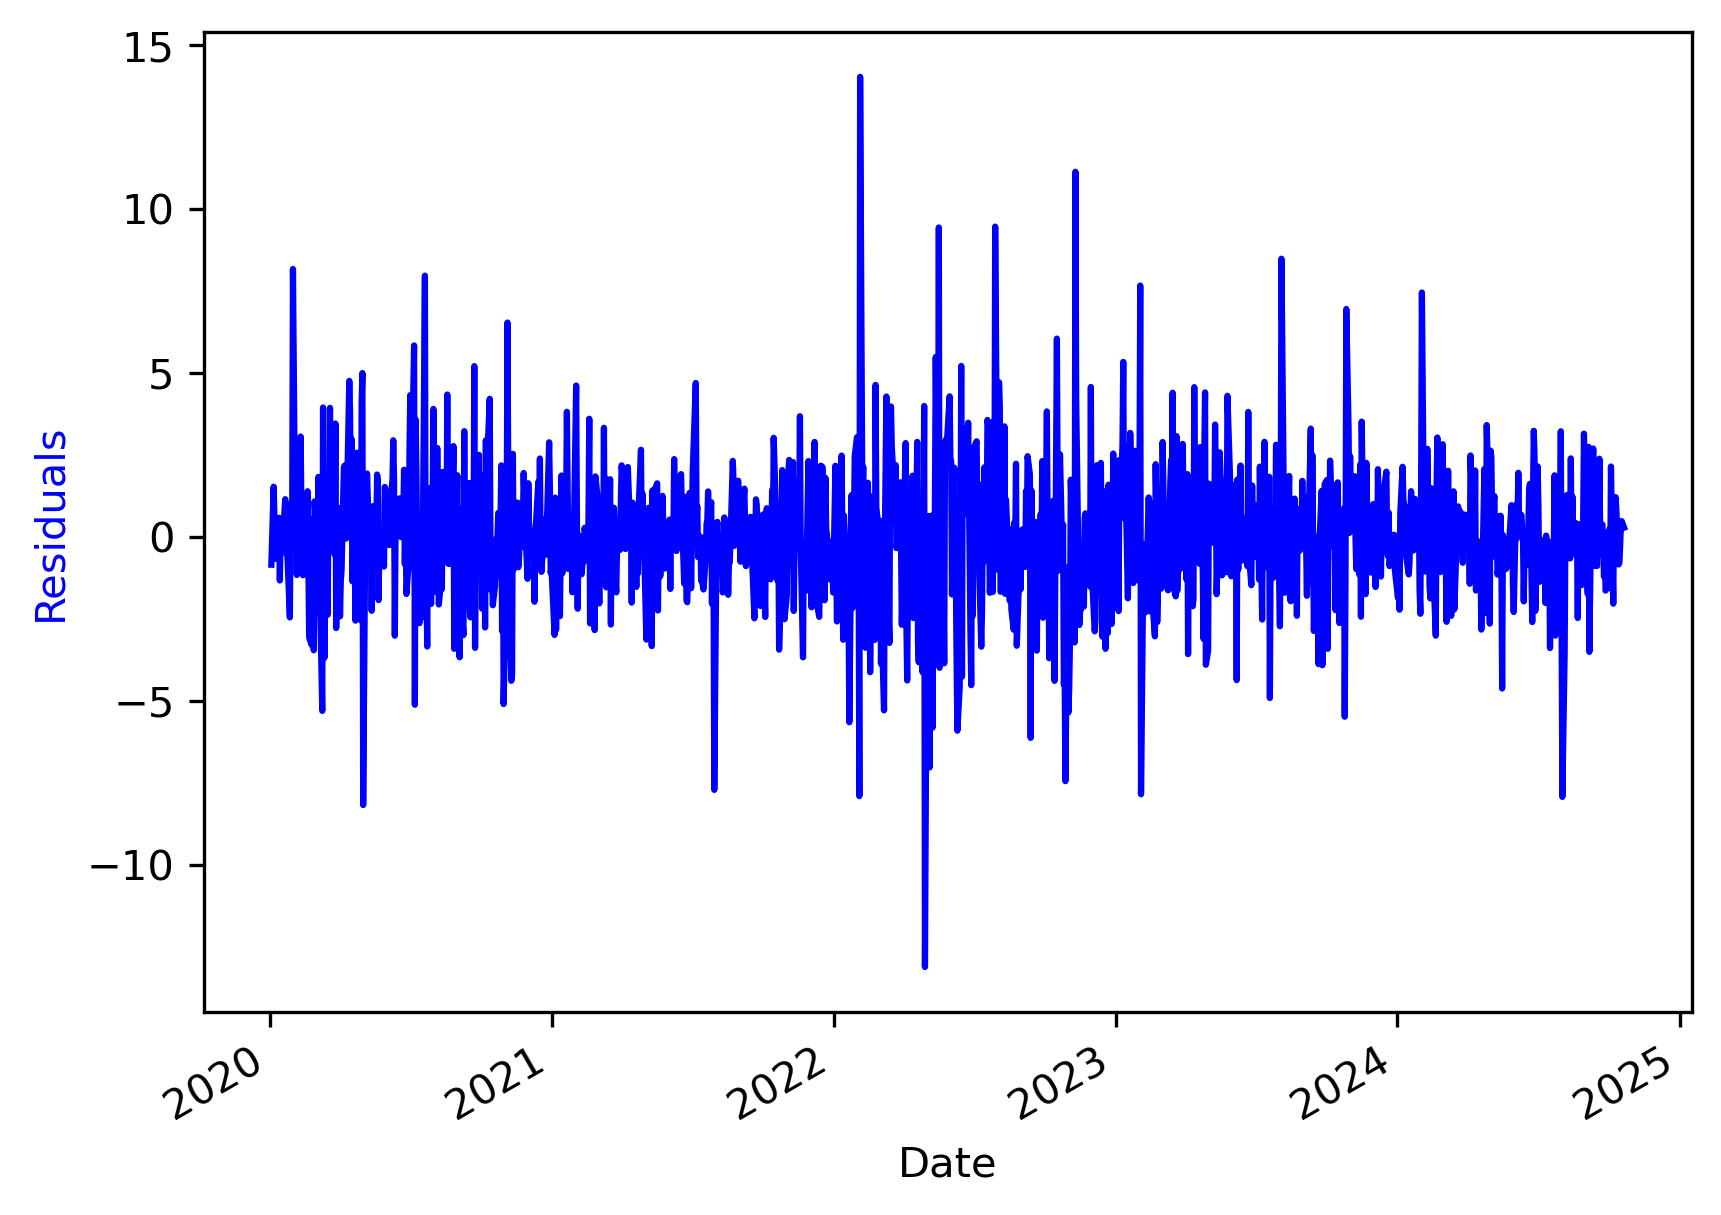

In [66]:
# Check the residuals 

residuals = results.resid

# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Residuals Rate Plot
residuals.plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Residuals', 
    color='blue'
    )

plt.show()

In [67]:
# Let us check some important things

print(f"The Residuals Mean is: {residuals.mean().round(3)}")
print(f"The Residuals Variance is: {residuals.var()}")

The Residuals Mean is: -0.0
The Residuals Variance is: 4.719652857373507


In [68]:
# Test for Heteroskedasticity

bp_test = het_breuschpagan(
    residuals, 
    sm.add_constant(ols_df['x'])
)

labels = ['LM statistic', 'p-value', 'F-statistic', 'F p-value']
print(dict(zip(labels, bp_test)))

{'LM statistic': 8.124045439908173, 'p-value': 0.004368197702682842, 'F-statistic': 8.165509745648093, 'F p-value': 0.004342796551853817}


In [69]:
# Omega

Omega = np.diag(residuals**2)

print(Omega)

[[0.71632466 0.         0.         ... 0.         0.         0.        ]
 [0.         2.35531236 0.         ... 0.         0.         0.        ]
 [0.         0.         0.35684834 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.23475905 0.         0.        ]
 [0.         0.         0.         ... 0.         0.23296676 0.        ]
 [0.         0.         0.         ... 0.         0.         0.0801579 ]]


In [70]:
# The weighted least squares formula

display(Math(r"\beta_{gls}=(X^⊤WX)^{-1}(X^⊤WY)"))

# In this case

display(Math(r"\Omega^{-1}=W"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [71]:
# If we want to replicate it we have to create the matrix

# Y Vector
Y_Vector = ols_df["y"].to_numpy()

# X matrix
Information_Matrix = ols_df[['constant', 'x']].to_numpy()

# Weights

W = np.linalg.inv(Omega)

print(W.round(4))

[[ 1.396   0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.4246  0.     ...  0.      0.      0.    ]
 [ 0.      0.      2.8023 ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  4.2597  0.      0.    ]
 [ 0.      0.      0.     ...  0.      4.2925  0.    ]
 [ 0.      0.      0.     ...  0.      0.     12.4754]]


In [72]:
# Calculate the Weighted Data

Weighted_X = W.dot(Information_Matrix)
Weighted_Y = W.dot(Y_Vector)

In [73]:
# Calculate the components

Information_Matrix_T = Information_Matrix.transpose()

X_Weighted_Var = Information_Matrix_T.dot(Weighted_X)
X_Y_Weighted_Covar = Information_Matrix_T.dot(Weighted_Y)

X_Weighted_Var_Inv = np.linalg.inv(X_Weighted_Var)

In [74]:
# The betas

betas_gls = X_Weighted_Var_Inv.dot(X_Y_Weighted_Covar)

print(betas_gls.round(4))

[0.0509 0.4701]


In [75]:
# GLS

gls_model = sm.GLS(
    ols_df['y'], 
    sm.add_constant(ols_df['x']),
    sigma=Omega
)

#the results of the model
gls_results = gls_model.fit()

#here we check the summary
print(gls_results.summary())    

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            GLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 7.830e+04
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:18:25   Log-Likelihood:                -1674.1
No. Observations:                1208   AIC:                             3352.
Df Residuals:                    1206   BIC:                             3362.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0509      0.002     25.426      0.0

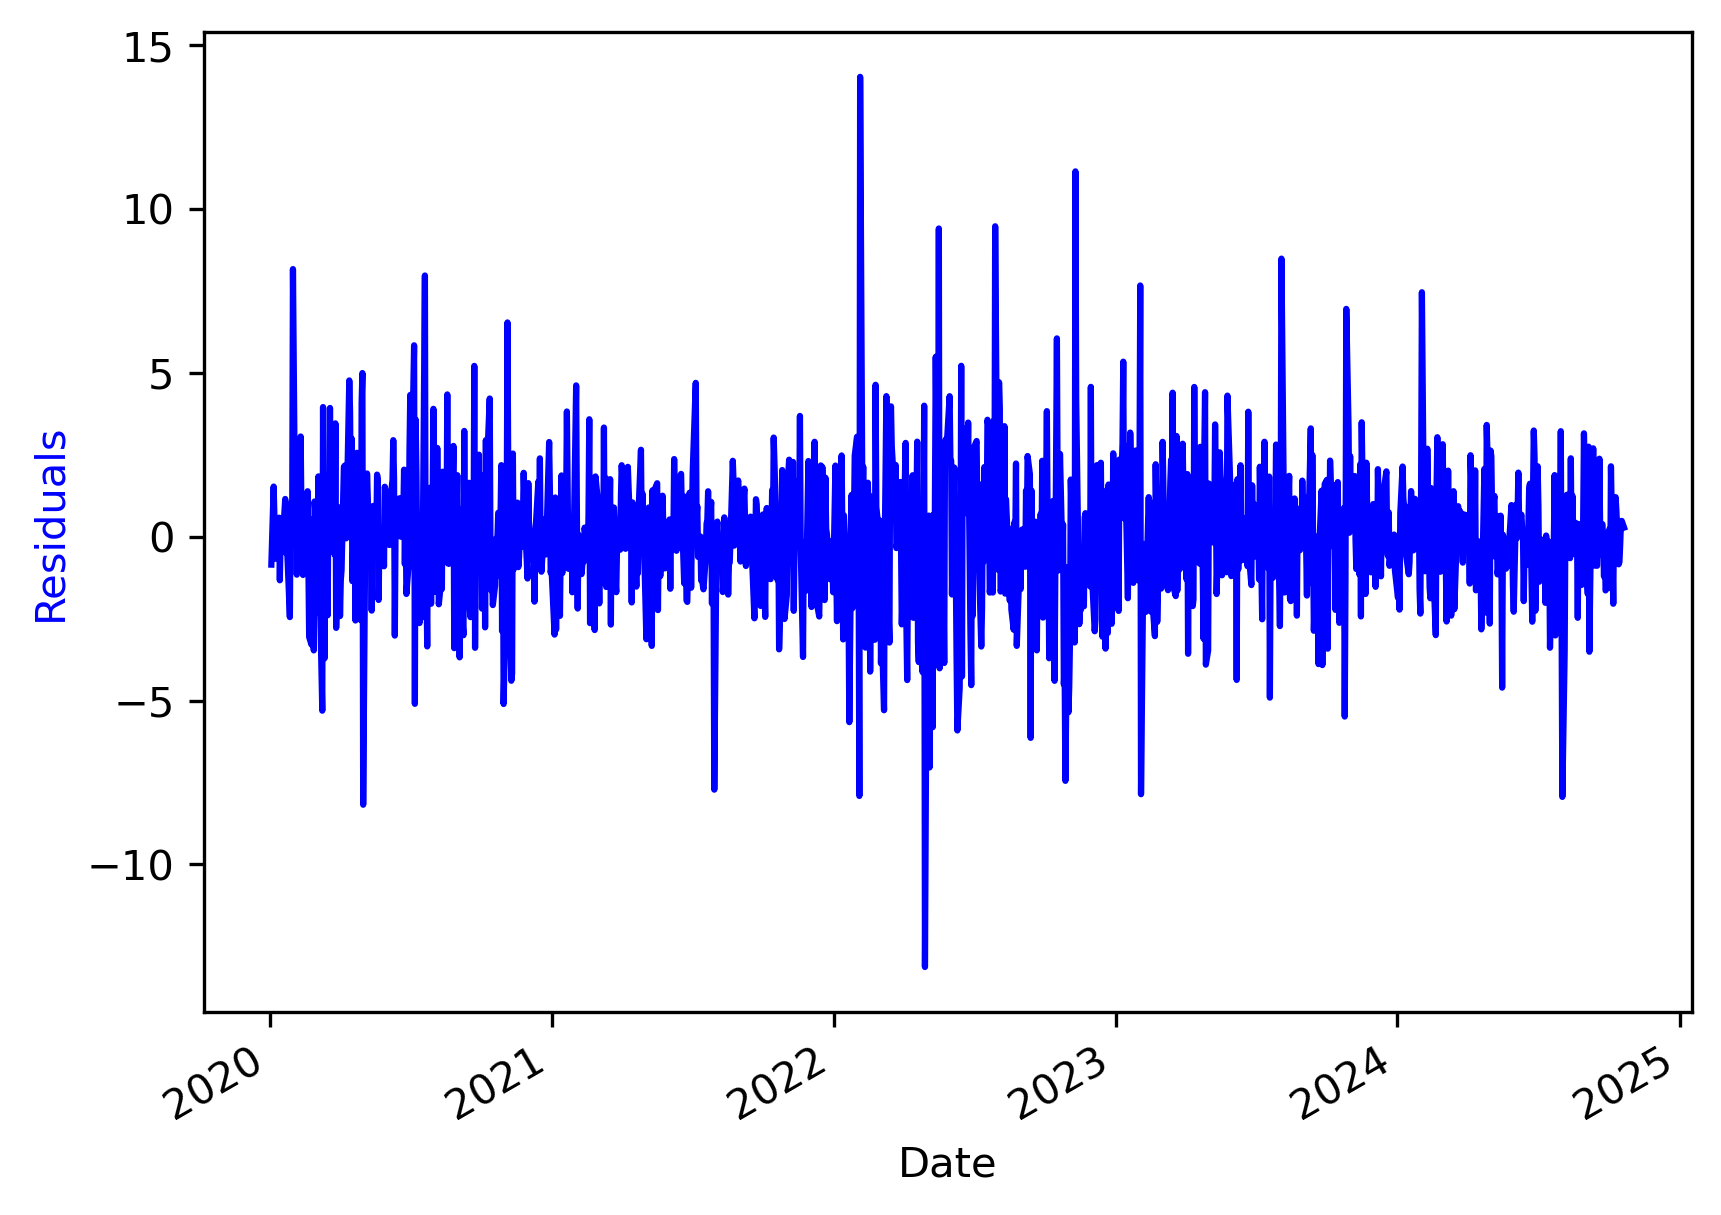

In [76]:
# Check the residuals 

residuals_gls = gls_results.resid

# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Residuals Rate Plot
residuals_gls.plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Residuals', 
    color='blue'
    )

plt.show()

In [102]:
# Calculate the Sums of Squares

# First the Weighted Mean
y_w_mean = np.sum(W.diagonal() * y) / np.sum(W)

# The Fitted Values
y_hat_gls = gls_results.fittedvalues

0.07498721530176561

In [112]:
# Calculate the Total Sum of Squares

SST_wls = np.sum(W.diagonal() * (y - y_w_mean)**2)

SST_wls

79409.32972444463

In [116]:
# Calculate the Residual Sum of Squares

SSR_wls = np.sum(W.diagonal() * (y - y_hat_gls)**2)

SSR_wls

1204.4668528630355

In [118]:
# Calculate the R-Squared

R_Squared_GLS = 1 - (SSR_wls/SST_wls)

R_Squared_GLS

0.9848321745436889